Project : The Product Pricer

A model that can estimate how much something costs, from its description.

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

## Data Curation Part 1

In [ ]:
#import packages
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt

In [ ]:
# import environment variables 
load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN')

In [ ]:
# Log in to HuggingFace
hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [44]:
#import Itenm function from items.py file
from items import Item

In [42]:
%matplotlib inline

In [43]:
# Load in our dataset
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full", trust_remote_code=True)

In [ ]:
#review the length of dataset 
print(f"Number of Appliances: {len(dataset):,}")

In [46]:
#review one datapoint in a dataset
datapoint = dataset[0]

In [47]:
# review all values in the datapoint

print(datapoint["title"])
print(datapoint["description"])
print(datapoint["features"])
print(datapoint["details"])
print(datapoint["price"])

ROVSUN Ice Maker Machine Countertop, Make 44lbs Ice in 24 Hours, Compact & Portable Ice Maker with Ice Basket for Home, Office, Kitchen, Bar (Silver)
[]
['【Quick Ice Making】This countertop ice machine creates crystal & bullet shaped ice cubes; 44lbs of ice ready in 24 hours, 12 cubes made per cycle within 10 mins; you can perfectly use it for drinks, wine, smoothies, food', '【Portable Design】The weight of this ice maker is only 23.3lbs, and the small size (10.63 x14.37 x 12.87)" makes it portable. It\'s compact feature is perfect for home, office, apartments, dormitories, RVs and more, it can be placed on countertop or tabletop, plug it anywhere you like', '【Simple Operation】Adding the water tank with purified water; Power on machine and press "on/off" button to start ice making process; After 8-12 minutes, ice cube will fall off into the ice basket automatically; Take it out and make you cool', '【Full Monitoring】 Designed with compressor cooling system, operates at low noise and will 

In [48]:
# How many have prices?

prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")

There are 46,726 with prices which is 49.5%


In [49]:
# For those with prices, gather the price and the length

prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError as e:
        pass

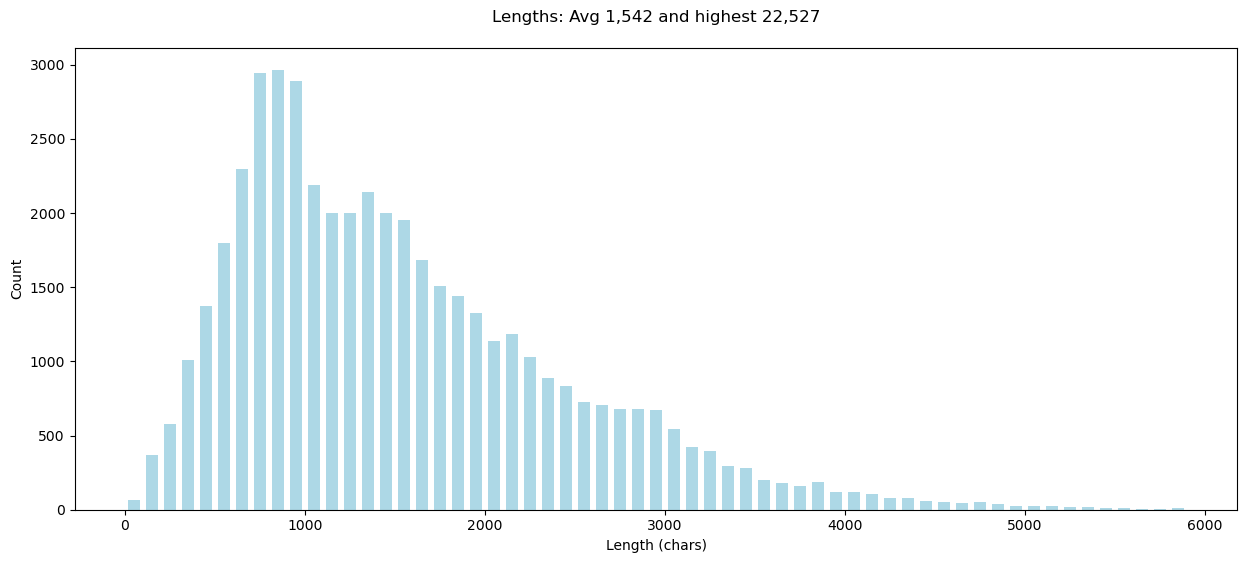

In [50]:
# Plot the distribution of lengths
plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

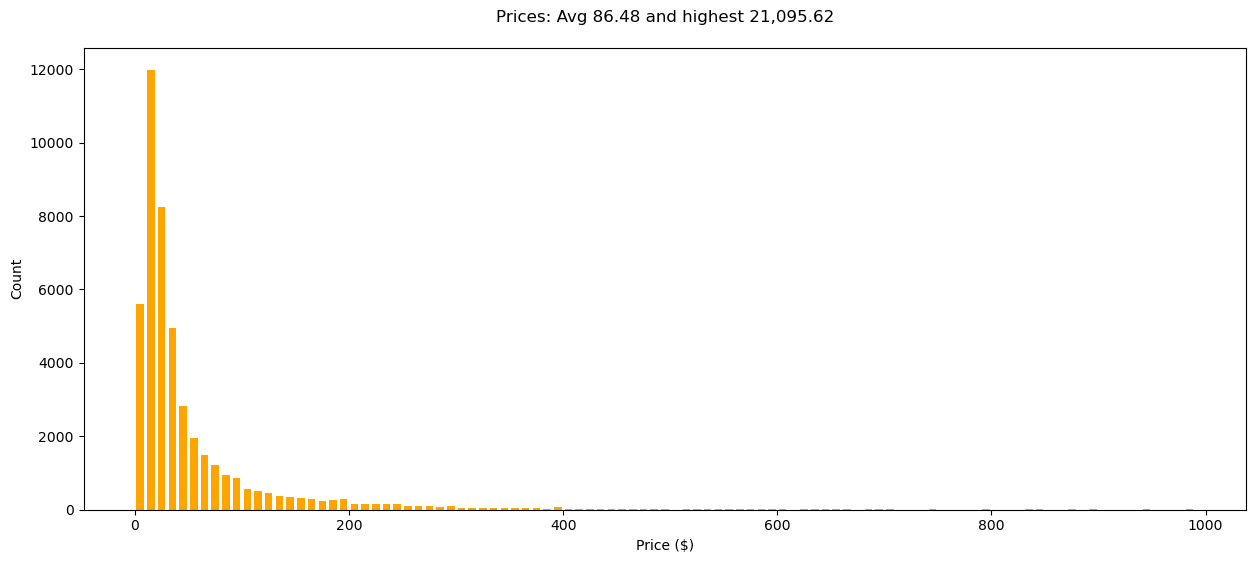

In [51]:
# Plot the distribution of prices
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [52]:
# So what is this item??
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 21000:
            print(datapoint['title'])
    except ValueError as e:
        pass

TurboChef BULLET Rapid Cook Electric Microwave Convection Oven


- Curate data 

In [53]:
# Create an Item object for each with a price

items = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

There are 30,601 items


In [55]:
#review one of the item 
items[1]

<WP67003405 67003405 Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces AP6010352 8208254 PS11743531 - Quick DIY Repair Solution = $16.52>

In [56]:
# lets look at a  prompt that will be used during model training
# the model learns to complete this 
print(items[100].prompt)

How much does this cost to the nearest dollar?

Refrigerator Water Inlet Valve 1/4 Inlet Fitting Icemaker Water Inlet Valve with Guard Replaces
❄❄PART DESCRIPTION single outlet valve with guard provides water for ice maker and water dispenser. refrigerator water valve has 1/4 inlet connector and new quick connect outlet connector ❄❄REPLACE PARTS NUMBERS can directly replace the following models MV469, (Please make sure your model is correct before placing an order, if you are unsure, you can contact us at any time) ❄❄EASY INSTALLATION water inlet valve can solve the following problems Ice maker leaked.; the dispenser does not work; the ice maker does not make ice. Tools for the installation process require a screwdriver and wrench, no additional screws are required, allowing

Price is $19.00


In [57]:
# lets look at a  prompt that will be used during model testing
# the model learns to complete this 
print(items[100].test_prompt)

<bound method Item.test_prompt of <WR57X10033 Refrigerator Water Inlet Valve 1/4" Inlet Fitting Icemaker Water Inlet Valve with Guard Replaces WR57X90 WR57X0093 WR57X0110 WR57X0096 = $18.99>>


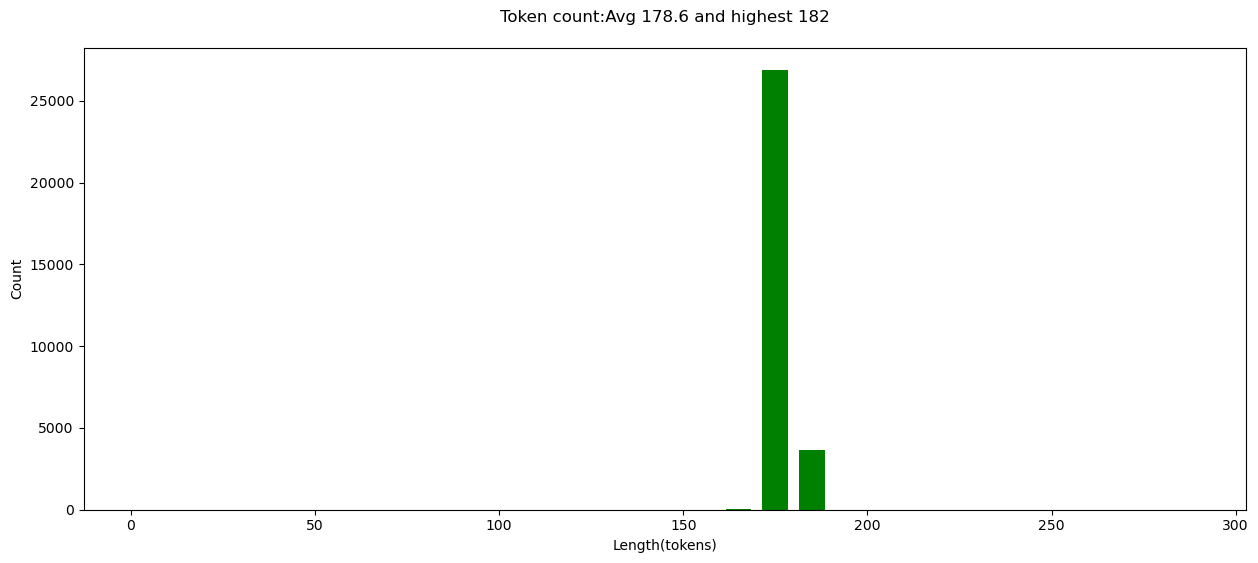

In [ ]:
#plot the dirstribution of token counts 
tokens= [item.token_count for item in items]
plt.figure(figsize = (15,6))
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0,300, 10))
plt.title(f"Token count:Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel("Length(tokens)")
plt.ylabel("Count")
plt.show()

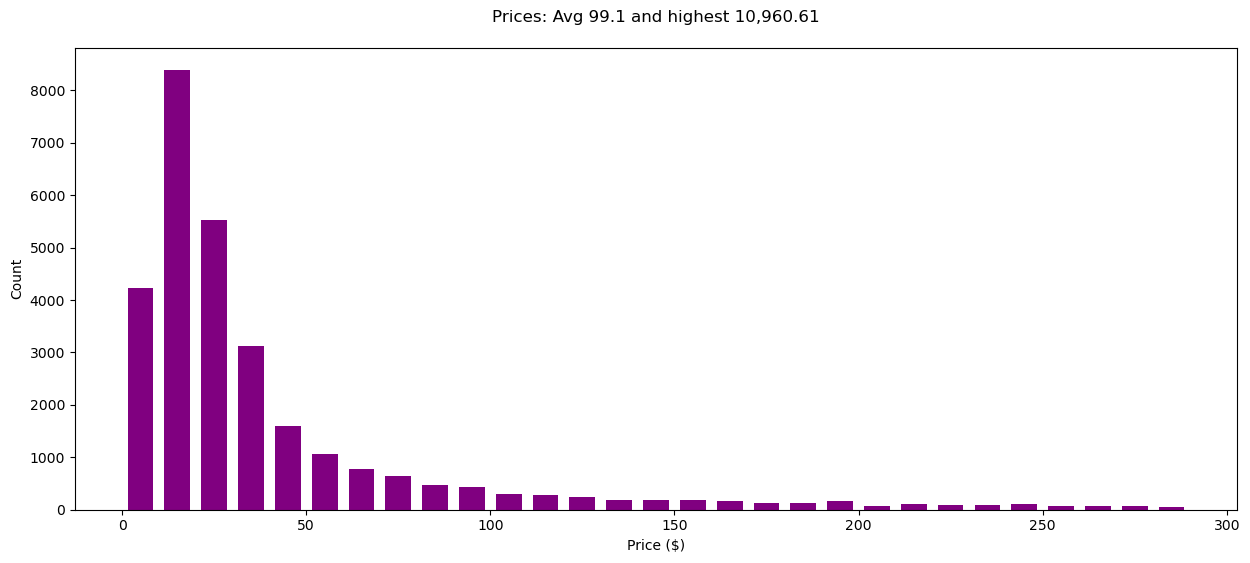

In [ ]:
# Plot the distribution of prices
prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 300, 10))
plt.show()